In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
import statsmodels.api as sm
from sklearn.cluster import KMeans
#import scikit_posthocs as sp
from scipy.stats import kruskal
from sklearn.utils import resample
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score

pd.set_option('display.max_columns', None)  # Отображение всех столбцов
# pd.set_option('display.max_rows', None)  # Ото----бражение всех строк   

regions = pd.read_csv('regions.csv')
starts = pd.read_csv('starts.csv')
volunteers = pd.read_csv('volunteers.csv')


volunteers = volunteers[volunteers.athlete_age < 100]
starts = starts[starts.athlete_age < 80]
starts = starts[starts.finish_time < 5000]

starts['rain.1h'] = starts['rain.1h'].fillna(0)
starts['snow.1h'] = starts['snow.1h'].fillna(0)

cnt_ludei = starts.groupby(['event_name', 'event_date', 'region']).agg(
    cnt_runners = ('athlete_id', 'count')
)

ages_14 = starts[starts['athlete_age'] == 14]['athlete_id'].unique()
ages_15 = starts[starts['athlete_age'] == 15]['athlete_id'].unique()
common_athletes = set(ages_14) & set(ages_15)
starts = starts[~starts['athlete_id'].isin(common_athletes)]



starts['is_male'] = starts['athlete_gender'].apply(lambda x: 1 if x == 'мужской' else 0)
starts = starts[starts['athlete_age'] > 14]

volunteer_counts = volunteers.groupby(['event_date','event_name', 'volunteer_role_name']).size().unstack(fill_value=0)  
starts = starts.merge(volunteer_counts, on=['event_date','event_name'], how='left')  

starts = starts.dropna(subset=[col for col in starts.columns if col not in ['snow.1h', 'rain.1h']])   # удаление где 0 волонтеров в сумме было


unique_dates = (
    pd.concat([
        starts[['athlete_id', 'event_date']],
        volunteers[['athlete_id', 'event_date']]
    ])
    .drop_duplicates()
)
date_counts = unique_dates.groupby('athlete_id').size().reset_index(name='unique_event_count')
date_counts['is_repeated'] = (date_counts['unique_event_count'] > 1).astype(int)
starts = starts.merge(date_counts[['athlete_id', 'is_repeated']], on='athlete_id', how='left')


# starts = starts[~starts['region'].isin(['Республика Адыгея', 'Республика Карелия', 'Липецкая область', 'Сахалинская область', 'Архангельская область'])]  
starts = starts[starts.event_date <= '2023-11-15']


newbie = starts[starts['is_newbie'] == 1]
first_runs = newbie.sort_values(by='event_date').drop_duplicates('athlete_id')
didnt_come = first_runs[first_runs.is_repeated == 0]
come = first_runs[first_runs.is_repeated == 1]
come_with_didnt_come = pd.concat([come, didnt_come])
come_with_didnt_come['cnt_volunteers'] = come_with_didnt_come.iloc[:, 24:51].sum(axis=1)
come_with_didnt_come = come_with_didnt_come.merge(cnt_ludei,on=['event_name', 'event_date', 'region'], how="left")
print(len(come_with_didnt_come))

18114


In [57]:
df = starts
runs_per_participant = df.groupby('athlete_id').size()

# Проверка на пропущенные значения и корректность данных
runs_per_participant = runs_per_participant.dropna()
runs_per_participant = runs_per_participant[runs_per_participant >= 0]

# Вычисление среднего количества пробежек
average_runs = runs_per_participant.mean()

print(f"Среднее количество пробежек на участника: {average_runs:.2f}")

Среднее количество пробежек на участника: 5.46


In [58]:
df = come_with_didnt_come
runs_per_participant = df.groupby('athlete_id').size()

# Проверка на пропущенные значения и корректность данных
runs_per_participant = runs_per_participant.dropna()
runs_per_participant = runs_per_participant[runs_per_participant >= 0]

# Вычисление среднего количества пробежек
average_runs = runs_per_participant.mean()

print(f"Среднее количество пробежек на участника: {average_runs:.2f}")

Среднее количество пробежек на участника: 1.00


Spearman correlation:
                cnt_runners  cnt_volunteers
cnt_runners         1.00000         0.56289
cnt_volunteers      0.56289         1.00000


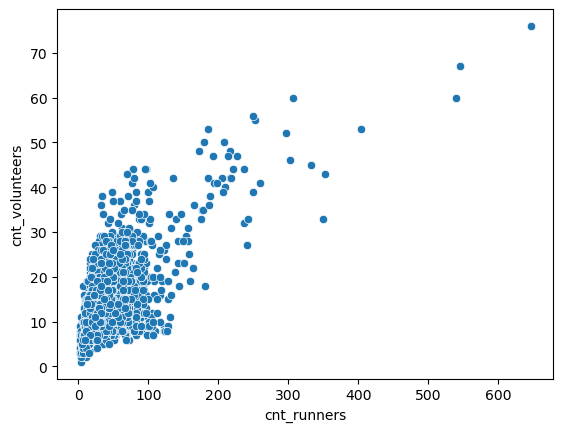

In [22]:
# Удаляем дубликаты по event_date и event_name
come_with_didnt_come_unique = come_with_didnt_come.drop_duplicates(subset=['event_date', 'event_name'])

# Строим новый scatter plot
sns.scatterplot(x=come_with_didnt_come_unique['cnt_runners'], 
                y=come_with_didnt_come_unique['cnt_volunteers'])

# Считаем корреляцию Спирмена
corr_spearman = come_with_didnt_come_unique[['cnt_runners', 'cnt_volunteers']].corr(method='spearman')
print("Spearman correlation:")
print(corr_spearman)


In [34]:
import pandas as pd
import heapq
from collections import deque

# Фильтруем события, где количество волонтёров по сканированию не равно 0
come_with_didnt_come = come_with_didnt_come[(come_with_didnt_come['cnt_runners'] >= 2) & (come_with_didnt_come['cnt_runners'] <= 47)]
come_with_didnt_come = come_with_didnt_come[come_with_didnt_come['Сканирование штрих-кодов'] != 0]
come_with_didnt_come['cnt_volunteers_scanning'] = come_with_didnt_come['Сканирование штрих-кодов']

def simulate_scanning(event_df, scan_time=15):
    # Сортируем бегунов по времени финиша
    event_df = event_df.sort_values('finish_time')
    
    # Получаем количество волонтёров и приводим к целому числу
    volunteers = event_df['cnt_volunteers_scanning'].iloc[0]
    
    # Проверяем корректность количества волонтёров
    if pd.isna(volunteers) or volunteers <= 0:
        return None, None, None  # Возвращаем None, если данные некорректны
    
    volunteers = int(volunteers)
    
    # Инициализируем кучу времен освобождения волонтёров (все свободны с начала)
    volunteer_heap = [0] * volunteers
    heapq.heapify(volunteer_heap)
    
    waiting_queue = deque()
    max_queue_length = 0
    total_wait_time = 0
    waiting_count = 0
    queue_count = 0
    queue_active = False  # Флаг, указывающий, активна ли очередь
    
    for _, runner in event_df.iterrows():
        arrival_time = runner['finish_time']
        
        # Освобождаем волонтёров, которые свободны к моменту прибытия бегуна
        while waiting_queue and volunteer_heap[0] <= arrival_time:
            volunteer_free_time = heapq.heappop(volunteer_heap)
            waiting_runner_arrival = waiting_queue.popleft()
            start_scan = max(volunteer_free_time, waiting_runner_arrival)
            end_scan = start_scan + scan_time
            heapq.heappush(volunteer_heap, end_scan)
            wait_time = start_scan - waiting_runner_arrival
            total_wait_time += wait_time
            waiting_count += 1
            
            # Если очередь опустела, сбрасываем флаг активности очереди
            if not waiting_queue:
                queue_active = False
    
        # Обрабатываем текущего бегуна
        if volunteer_heap[0] <= arrival_time:
            # Есть свободный волонтёр
            volunteer_free_time = heapq.heappop(volunteer_heap)
            start_scan = arrival_time
            end_scan = start_scan + scan_time
            heapq.heappush(volunteer_heap, end_scan)
        else:
            # Нет свободных волонтёров, бегун встаёт в очередь
            waiting_queue.append(arrival_time)
            current_queue_length = len(waiting_queue)
            if current_queue_length > max_queue_length:
                max_queue_length = current_queue_length
                
            # Если очередь не была активна, увеличиваем счётчик очередей
            if not queue_active:
                queue_count += 1
                queue_active = True
    
    # Обрабатываем оставшихся бегунов в очереди после завершения основного потока
    while waiting_queue:
        volunteer_free_time = heapq.heappop(volunteer_heap)
        waiting_runner_arrival = waiting_queue.popleft()
        start_scan = max(volunteer_free_time, waiting_runner_arrival)
        end_scan = start_scan + scan_time
        heapq.heappush(volunteer_heap, end_scan)
        wait_time = start_scan - waiting_runner_arrival
        total_wait_time += wait_time
        waiting_count += 1
        
        if not waiting_queue:
            queue_active = False
    
    avg_wait_time = total_wait_time / waiting_count if waiting_count > 0 else 0
    return max_queue_length, avg_wait_time, queue_count

# Пример использования:
# Предполагается, что у вас есть DataFrame `come_with_didnt_come` со следующими колонками:
# ['event_name', 'event_date', 'finish_time', 'Сканирование штрих-кодов']

# Убедимся, что 'cnt_volunteers_scanning' является целым числом
come_with_didnt_come['cnt_volunteers_scanning'] = come_with_didnt_come['cnt_volunteers_scanning'].astype(int)

results = []
for (ename, edate), group in come_with_didnt_come.groupby(['event_name', 'event_date']):
    max_queue, avg_wait, queue_count = simulate_scanning(group, scan_time=15)
    if max_queue is not None:
        results.append({
            'event_name': ename,
            'event_date': edate,
            'max_queue_length': max_queue,
            'avg_wait_time': avg_wait,
            'queue_count': queue_count
        })
    else:
        results.append({
            'event_name': ename,
            'event_date': edate,
            'max_queue_length': 'N/A',
            'avg_wait_time': 'N/A',
            'queue_count': 'N/A'
        })

results_df = pd.DataFrame(results)
print(results_df)


         event_name  event_date  max_queue_length  avg_wait_time  queue_count
0      Александрино  2023-04-15                 1           10.0            2
1      Александрино  2023-04-22                 1           15.0            1
2      Александрино  2023-04-29                 0            0.0            0
3      Александрино  2023-05-06                 0            0.0            0
4      Александрино  2023-05-13                 0            0.0            0
...             ...         ...               ...            ...          ...
2797  Якутск Дохсун  2023-09-16                 0            0.0            0
2798  Якутск Дохсун  2023-09-30                 0            0.0            0
2799  Якутск Дохсун  2023-10-07                 0            0.0            0
2800  Якутск Дохсун  2023-10-14                 1           12.0            1
2801  Якутск Дохсун  2023-10-21                 0            0.0            0

[2802 rows x 5 columns]


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='queue_count', ylabel='Count'>

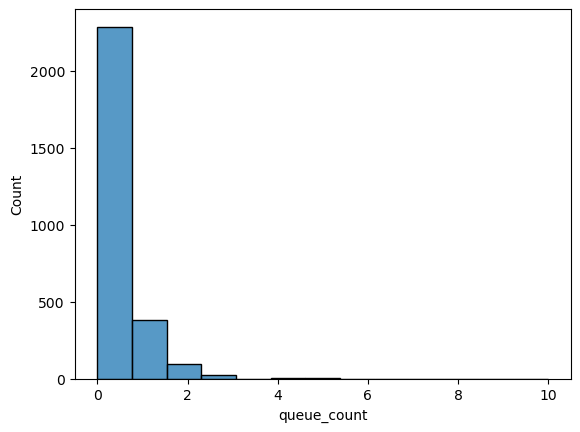

In [35]:
sns.histplot(results_df['queue_count'])

In [36]:
results_df.queue_count.value_counts()

queue_count
0     2285
1      381
2       98
3       22
4        7
5        5
10       1
8        1
7        1
6        1
Name: count, dtype: int64

In [ ]:
come_with_didnt_come = come_with_didnt_come[come_with_didnt_come['Сканирование штрих-кодов'] != 0]

In [43]:
import pandas as pd
import heapq
from collections import deque

# Фильтруем события, где количество волонтёров по сканированию не равно 0
come_with_didnt_come = come_with_didnt_come[(come_with_didnt_come['cnt_runners'] >= 47) & (come_with_didnt_come['cnt_runners'] <= 138)]
come_with_didnt_come = come_with_didnt_come[come_with_didnt_come['Сканирование штрих-кодов'] != 0]
come_with_didnt_come['cnt_volunteers_scanning'] = come_with_didnt_come['Сканирование штрих-кодов']

def simulate_scanning(event_df, scan_time=15):
    # Сортируем бегунов по времени финиша
    event_df = event_df.sort_values('finish_time')
    
    # Получаем количество волонтёров и приводим к целому числу
    volunteers = event_df['cnt_volunteers_scanning'].iloc[0]
    
    # Проверяем корректность количества волонтёров
    if pd.isna(volunteers) or volunteers <= 0:
        return None, None, None  # Возвращаем None, если данные некорректны
    
    volunteers = int(volunteers)
    
    # Инициализируем кучу времен освобождения волонтёров (все свободны с начала)
    volunteer_heap = [0] * volunteers
    heapq.heapify(volunteer_heap)
    
    waiting_queue = deque()
    max_queue_length = 0
    total_wait_time = 0
    waiting_count = 0
    queue_count = 0
    queue_active = False  # Флаг, указывающий, активна ли очередь
    
    for _, runner in event_df.iterrows():
        arrival_time = runner['finish_time']
        
        # Освобождаем волонтёров, которые свободны к моменту прибытия бегуна
        while waiting_queue and volunteer_heap[0] <= arrival_time:
            volunteer_free_time = heapq.heappop(volunteer_heap)
            waiting_runner_arrival = waiting_queue.popleft()
            start_scan = max(volunteer_free_time, waiting_runner_arrival)
            end_scan = start_scan + scan_time
            heapq.heappush(volunteer_heap, end_scan)
            wait_time = start_scan - waiting_runner_arrival
            total_wait_time += wait_time
            waiting_count += 1
            
            # Если очередь опустела, сбрасываем флаг активности очереди
            if not waiting_queue:
                queue_active = False
    
        # Обрабатываем текущего бегуна
        if volunteer_heap[0] <= arrival_time:
            # Есть свободный волонтёр
            volunteer_free_time = heapq.heappop(volunteer_heap)
            start_scan = arrival_time
            end_scan = start_scan + scan_time
            heapq.heappush(volunteer_heap, end_scan)
        else:
            # Нет свободных волонтёров, бегун встаёт в очередь
            waiting_queue.append(arrival_time)
            current_queue_length = len(waiting_queue)
            if current_queue_length > max_queue_length:
                max_queue_length = current_queue_length
                
            # Если очередь не была активна, увеличиваем счётчик очередей
            if not queue_active:
                queue_count += 1
                queue_active = True
    
    # Обрабатываем оставшихся бегунов в очереди после завершения основного потока
    while waiting_queue:
        volunteer_free_time = heapq.heappop(volunteer_heap)
        waiting_runner_arrival = waiting_queue.popleft()
        start_scan = max(volunteer_free_time, waiting_runner_arrival)
        end_scan = start_scan + scan_time
        heapq.heappush(volunteer_heap, end_scan)
        wait_time = start_scan - waiting_runner_arrival
        total_wait_time += wait_time
        waiting_count += 1
        
        if not waiting_queue:
            queue_active = False
    
    avg_wait_time = total_wait_time / waiting_count if waiting_count > 0 else 0
    return max_queue_length, avg_wait_time, queue_count

# Пример использования:
# Предполагается, что у вас есть DataFrame `come_with_didnt_come` со следующими колонками:
# ['event_name', 'event_date', 'finish_time', 'Сканирование штрих-кодов']

# Убедимся, что 'cnt_volunteers_scanning' является целым числом
come_with_didnt_come['cnt_volunteers_scanning'] = come_with_didnt_come['cnt_volunteers_scanning'].astype(int)

results = []
for (ename, edate), group in come_with_didnt_come.groupby(['event_name', 'event_date']):
    max_queue, avg_wait, queue_count = simulate_scanning(group, scan_time=15)
    if max_queue is not None:
        results.append({
            'event_name': ename,
            'event_date': edate,
            'max_queue_length': max_queue,
            'avg_wait_time': avg_wait,
            'queue_count': queue_count
        })
    else:
        results.append({
            'event_name': ename,
            'event_date': edate,
            'max_queue_length': 'N/A',
            'avg_wait_time': 'N/A',
            'queue_count': 'N/A'
        })

results_df = pd.DataFrame(results)
print(results_df)


               event_name  event_date  max_queue_length  avg_wait_time  \
0            Александрино  2023-04-08                 0       0.000000   
1    Бабушкинский на Яузе  2023-06-10                 1      13.000000   
2    Бабушкинский на Яузе  2023-06-24                 0       0.000000   
3    Бабушкинский на Яузе  2023-10-07                 0       0.000000   
4    Бабушкинский на Яузе  2023-10-28                 0       0.000000   
..                    ...         ...               ...            ...   
810             Швейцария  2023-08-26                 3      18.571429   
811             Швейцария  2023-09-23                 3      19.500000   
812           Южноуральск  2023-09-23                 3      17.105263   
813         Якутск Дохсун  2023-04-29                 3       7.533333   
814         Якутск Дохсун  2023-06-10                 2       9.500000   

     queue_count  
0              0  
1              1  
2              0  
3              0  
4              0

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='queue_count', ylabel='Count'>

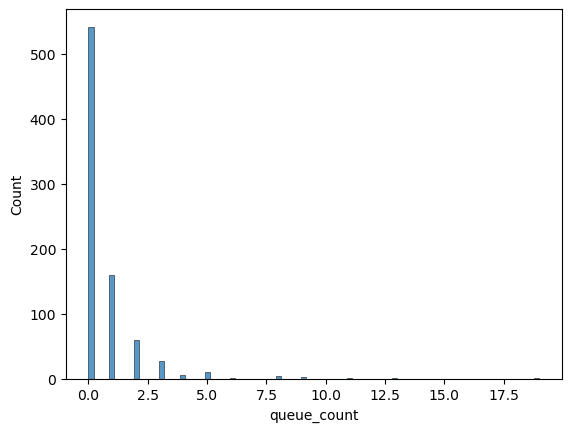

In [44]:
sns.histplot(results_df['queue_count'])

In [45]:
results_df.queue_count.value_counts()

queue_count
0     542
1     160
2      60
3      27
5      10
4       6
8       4
9       2
6       1
19      1
13      1
11      1
Name: count, dtype: int64

In [53]:
import pandas as pd
import heapq
from collections import deque

# Фильтруем события, где количество волонтёров по сканированию не равно 0
come_with_didnt_come = come_with_didnt_come[(come_with_didnt_come['cnt_runners'] >= 138) & (come_with_didnt_come['cnt_runners'] <= 404)]
come_with_didnt_come = come_with_didnt_come[come_with_didnt_come['Сканирование штрих-кодов'] != 0]
come_with_didnt_come['cnt_volunteers_scanning'] = come_with_didnt_come['Сканирование штрих-кодов']

def simulate_scanning(event_df, scan_time=15):
    # Сортируем бегунов по времени финиша
    event_df = event_df.sort_values('finish_time')
    
    # Получаем количество волонтёров и приводим к целому числу
    volunteers = event_df['cnt_volunteers_scanning'].iloc[0]
    
    # Проверяем корректность количества волонтёров
    if pd.isna(volunteers) or volunteers <= 0:
        return None, None, None  # Возвращаем None, если данные некорректны
    
    volunteers = int(volunteers)
    
    # Инициализируем кучу времен освобождения волонтёров (все свободны с начала)
    volunteer_heap = [0] * volunteers
    heapq.heapify(volunteer_heap)
    
    waiting_queue = deque()
    max_queue_length = 0
    total_wait_time = 0
    waiting_count = 0
    queue_count = 0
    queue_active = False  # Флаг, указывающий, активна ли очередь
    
    for _, runner in event_df.iterrows():
        arrival_time = runner['finish_time']
        
        # Освобождаем волонтёров, которые свободны к моменту прибытия бегуна
        while waiting_queue and volunteer_heap[0] <= arrival_time:
            volunteer_free_time = heapq.heappop(volunteer_heap)
            waiting_runner_arrival = waiting_queue.popleft()
            start_scan = max(volunteer_free_time, waiting_runner_arrival)
            end_scan = start_scan + scan_time
            heapq.heappush(volunteer_heap, end_scan)
            wait_time = start_scan - waiting_runner_arrival
            total_wait_time += wait_time
            waiting_count += 1
            
            # Если очередь опустела, сбрасываем флаг активности очереди
            if not waiting_queue:
                queue_active = False
    
        # Обрабатываем текущего бегуна
        if volunteer_heap[0] <= arrival_time:
            # Есть свободный волонтёр
            volunteer_free_time = heapq.heappop(volunteer_heap)
            start_scan = arrival_time
            end_scan = start_scan + scan_time
            heapq.heappush(volunteer_heap, end_scan)
        else:
            # Нет свободных волонтёров, бегун встаёт в очередь
            waiting_queue.append(arrival_time)
            current_queue_length = len(waiting_queue)
            if current_queue_length > max_queue_length:
                max_queue_length = current_queue_length
                
            # Если очередь не была активна, увеличиваем счётчик очередей
            if not queue_active:
                queue_count += 1
                queue_active = True
    
    # Обрабатываем оставшихся бегунов в очереди после завершения основного потока
    while waiting_queue:
        volunteer_free_time = heapq.heappop(volunteer_heap)
        waiting_runner_arrival = waiting_queue.popleft()
        start_scan = max(volunteer_free_time, waiting_runner_arrival)
        end_scan = start_scan + scan_time
        heapq.heappush(volunteer_heap, end_scan)
        wait_time = start_scan - waiting_runner_arrival
        total_wait_time += wait_time
        waiting_count += 1
        
        if not waiting_queue:
            queue_active = False
    
    avg_wait_time = total_wait_time / waiting_count if waiting_count > 0 else 0
    return max_queue_length, avg_wait_time, queue_count

# Пример использования:
# Предполагается, что у вас есть DataFrame `come_with_didnt_come` со следующими колонками:
# ['event_name', 'event_date', 'finish_time', 'Сканирование штрих-кодов']

# Убедимся, что 'cnt_volunteers_scanning' является целым числом
come_with_didnt_come['cnt_volunteers_scanning'] = come_with_didnt_come['cnt_volunteers_scanning'].astype(int)

results = []
for (ename, edate), group in come_with_didnt_come.groupby(['event_name', 'event_date']):
    max_queue, avg_wait, queue_count = simulate_scanning(group, scan_time=15)
    if max_queue is not None:
        results.append({
            'event_name': ename,
            'event_date': edate,
            'max_queue_length': max_queue,
            'avg_wait_time': avg_wait,
            'queue_count': queue_count
        })
    else:
        results.append({
            'event_name': ename,
            'event_date': edate,
            'max_queue_length': 'N/A',
            'avg_wait_time': 'N/A',
            'queue_count': 'N/A'
        })

results_df = pd.DataFrame(results)
print(results_df)


                                event_name  event_date  max_queue_length  \
0                                     ВДНХ  2023-07-22                 0   
1                                     ВДНХ  2023-10-21                 0   
2                            Елагин остров  2023-06-10                 2   
3                              Затюменский  2023-03-18                 0   
4                              Затюменский  2023-04-01                 0   
5                              Затюменский  2023-04-08                 0   
6                              Затюменский  2023-04-22                 1   
7                              Затюменский  2023-05-06                 0   
8                              Затюменский  2023-05-13                 0   
9                              Затюменский  2023-05-20                 1   
10                             Затюменский  2023-05-27                 1   
11                             Затюменский  2023-06-03                 0   
12          

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='queue_count', ylabel='Count'>

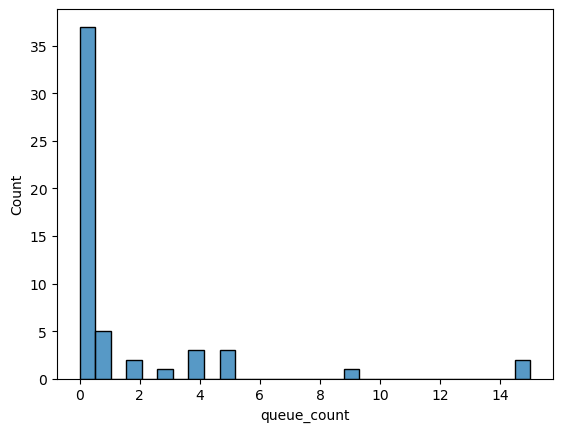

In [54]:
sns.histplot(results_df['queue_count'])

In [55]:
results_df.queue_count.value_counts()

queue_count
0     37
1      5
4      3
5      3
2      2
15     2
9      1
3      1
Name: count, dtype: int64

In [23]:
from scipy.stats import spearmanr

corr, p_value = spearmanr(come_with_didnt_come_unique['cnt_runners'], 
                          come_with_didnt_come_unique['cnt_volunteers'])

print("Spearman correlation coefficient:", corr)
print("p-value:", p_value)


Spearman correlation coefficient: 0.5628898670720853
p-value: 5.543490185838e-311


In [21]:
come_with_didnt_come['cnt_volunteers'].corr(come_with_didnt_come['cnt_runners'], method='spearman')

0.689217281094825

In [14]:
come_with_didnt_come.columns[24:51]

Index(['Ведущий велосипед', 'Завершение мероприятия', 'Замыкающий',
       'Инструктаж новых участников', 'Координатор парковки',
       'Координация волонтёров', 'Лидер для слабовидящих', 'Маршал',
       'Обработка результатов', 'Организатор', 'Организация финиша', 'Пейсер',
       'Подготовка мероприятия', 'Помощь в раздаче карточек позиций',
       'Проведение разминки', 'Проверка карточек позиций', 'Проверка трассы',
       'Раздача карточек позиций', 'Разное', 'Связи с общественностью',
       'Секундомер', 'Сканирование штрих-кодов', 'Сортировка карточек',
       'Составление отчёта', 'Сурдопереводчик', 'Фотограф',
       'Хранение и доставка оборудования'],
      dtype='object')

In [3]:
placeholder = come_with_didnt_come
come_with_didnt_come = placeholder[placeholder['athlete_gender'] == 'мужской']

In [4]:
X = come_with_didnt_come[(come_with_didnt_come.cnt_runners >= 2) & (come_with_didnt_come.cnt_runners <= 46)]
y = come_with_didnt_come[(come_with_didnt_come.cnt_runners >= 2) & (come_with_didnt_come.cnt_runners <= 46)]
print(len(come_with_didnt_come[(come_with_didnt_come.cnt_runners >= 2) & (come_with_didnt_come.cnt_runners <= 46)].drop_duplicates(['event_name', 'event_date'])))


need_columns = ['finish_time', 'athlete_age', 'feels_like', 'pressure', 'humidity', 'wind_speed', 
                'Ведущий велосипед', 
                'Завершение мероприятия', 'Замыкающий', 'Инструктаж новых участников', 'Маршал', 'Обработка результатов', 'Организатор',
                'Организация финиша', 'Пейсер', 'Подготовка мероприятия', 
            'Проверка карточек позиций', 'Проверка трассы', 'Раздача карточек позиций',
                'Разное', 'Связи с общественностью', 'Секундомер', 'Сканирование штрих-кодов', 'Сортировка карточек',
                'Фотограф', 'Хранение и доставка оборудования',
                  'cnt_runners'
                  ]
                






for col1 in need_columns:
    for col2 in need_columns:
        if col1 != col2:
            try:
                coef = X[col1].corr(X[col2],method='spearman')
                if abs(coef) > 0.8:
                    print('Возможна мультиколлинеарность: ', coef, col1, col2)
            except:
                print('ошибка в цикле на проверке корреляций между ', col1, " ", col2)

for_model = X[need_columns]


for_model = sm.add_constant(for_model)
y = y['is_repeated']
model = sm.Logit(y, for_model).fit()
print('\n')
print('Модель для предсказывания is_repeated новичка, в пробежках где было 2-46 людей')
print('\n')
print(model.summary())
marginal_effects = model.get_margeff()
print('\n')
print('Предельные эффекты:')
print(marginal_effects.summary())
print('\n')

y_pred = model.predict(for_model)
y_pred_class = (y_pred > 0.5).astype(int)  
cm = confusion_matrix(y, y_pred_class)
print(cm)
accuracy = (y_pred_class == y).mean()  
print(f'Accuracy: {accuracy:.2f}')  

2323
Optimization terminated successfully.
         Current function value: 0.651895
         Iterations 5


Модель для предсказывания is_repeated новичка, в пробежках где было 2-46 людей


                           Logit Regression Results                           
Dep. Variable:            is_repeated   No. Observations:                 4901
Model:                          Logit   Df Residuals:                     4873
Method:                           MLE   Df Model:                           27
Date:                Sun, 15 Dec 2024   Pseudo R-squ.:                 0.03157
Time:                        09:45:37   Log-Likelihood:                -3194.9
converged:                       True   LL-Null:                       -3299.1
Covariance Type:            nonrobust   LLR p-value:                 6.510e-30
                                       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------

Значим только инструктаж новых участников


In [5]:
X = come_with_didnt_come[(come_with_didnt_come.cnt_runners >= 47) & (come_with_didnt_come.cnt_runners <= 138)]
y = come_with_didnt_come[(come_with_didnt_come.cnt_runners >= 47) & (come_with_didnt_come.cnt_runners <= 138)]

print(len(come_with_didnt_come[(come_with_didnt_come.cnt_runners >= 47) & (come_with_didnt_come.cnt_runners <= 138)].drop_duplicates(['event_name', 'event_date'])))

need_columns = ['finish_time', 'athlete_age', 'feels_like', 'pressure', 'humidity', 'wind_speed', 
                'Ведущий велосипед', 
                'Завершение мероприятия', 'Замыкающий', 'Инструктаж новых участников', 'Маршал', 'Обработка результатов', 'Организатор',
                'Организация финиша', 'Пейсер', 'Подготовка мероприятия', 
            'Проверка карточек позиций', 'Проверка трассы', 'Раздача карточек позиций',
                'Разное', 'Связи с общественностью', 'Секундомер', 'Сканирование штрих-кодов', 'Сортировка карточек',
                'Фотограф', 'Хранение и доставка оборудования',
                  'cnt_runners'
                  ]
                






for col1 in need_columns:
    for col2 in need_columns:
        if col1 != col2:
            try:
                coef = X[col1].corr(X[col2],method='spearman')
                if abs(coef) > 0.8:
                    print('Возможна мультиколлинеарность: ', coef, col1, col2)
            except:
                print('ошибка в цикле на проверке корреляций между ', col1, " ", col2)

for_model = X[need_columns]


for_model = sm.add_constant(for_model)
y = y['is_repeated']
model = sm.Logit(y, for_model).fit()
print('\n')
print('Модель для предсказывания is_repeated новичка, в пробежках где было 47-138 людей')
print('\n')
print(model.summary())
marginal_effects = model.get_margeff()
print('\n')
print('Предельные эффекты:')
print(marginal_effects.summary())
print('\n')

y_pred = model.predict(for_model)
y_pred_class = (y_pred > 0.5).astype(int)  
cm = confusion_matrix(y, y_pred_class)
print(cm)
accuracy = (y_pred_class == y).mean()  
print(f'Accuracy: {accuracy:.2f}')  

775
Optimization terminated successfully.
         Current function value: 0.671251
         Iterations 4


Модель для предсказывания is_repeated новичка, в пробежках где было 47-138 людей


                           Logit Regression Results                           
Dep. Variable:            is_repeated   No. Observations:                 3361
Model:                          Logit   Df Residuals:                     3333
Method:                           MLE   Df Model:                           27
Date:                Sun, 15 Dec 2024   Pseudo R-squ.:                 0.02090
Time:                        09:46:39   Log-Likelihood:                -2256.1
converged:                       True   LL-Null:                       -2304.2
Covariance Type:            nonrobust   LLR p-value:                 1.030e-09
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------

значим только инструктаж новых участников

In [6]:
X = come_with_didnt_come[(come_with_didnt_come.cnt_runners >= 139) & (come_with_didnt_come.cnt_runners <= 404)]
y = come_with_didnt_come[(come_with_didnt_come.cnt_runners >= 139) & (come_with_didnt_come.cnt_runners <= 404)]
print(len(come_with_didnt_come[(come_with_didnt_come.cnt_runners >= 139) & (come_with_didnt_come.cnt_runners <= 404)].drop_duplicates(['event_name', 'event_date'])))



need_columns = ['finish_time', 'athlete_age', 'feels_like', 'pressure', 'humidity', 'wind_speed', 
                'Ведущий велосипед', 
                'Завершение мероприятия', 'Замыкающий', 'Инструктаж новых участников', 'Маршал', 'Обработка результатов', 'Организатор',
                'Организация финиша', 'Пейсер', 'Подготовка мероприятия', 
            'Проверка карточек позиций', 'Проверка трассы', 'Раздача карточек позиций',
                'Разное', 'Связи с общественностью', 'Секундомер', 'Сканирование штрих-кодов', 'Сортировка карточек',
                'Фотограф', 'Хранение и доставка оборудования',
                  'cnt_runners'
                  ]
                
                






for col1 in need_columns:
    for col2 in need_columns:
        if col1 != col2:
            try:
                coef = X[col1].corr(X[col2],method='spearman')
                if abs(coef) > 0.8:
                    print('Возможна мультиколлинеарность: ', coef, col1, col2)
            except:
                print('ошибка в цикле на проверке корреляций между ', col1, " ", col2)

for_model = X[need_columns]


for_model = sm.add_constant(for_model)
y = y['is_repeated']
model = sm.Logit(y, for_model).fit()
print('\n')
print('Модель для предсказывания is_repeated новичка, в пробежках где было 139-404 людей')
print('\n')
print(model.summary())
marginal_effects = model.get_margeff()
print('\n')
print('Предельные эффекты:')
print(marginal_effects.summary())
print('\n')

y_pred = model.predict(for_model)
y_pred_class = (y_pred > 0.5).astype(int)  
cm = confusion_matrix(y, y_pred_class)
print(cm)
accuracy = (y_pred_class == y).mean()  
print(f'Accuracy: {accuracy:.2f}')  

53
Optimization terminated successfully.
         Current function value: 0.643732
         Iterations 5


Модель для предсказывания is_repeated новичка, в пробежках где было 139-404 людей


                           Logit Regression Results                           
Dep. Variable:            is_repeated   No. Observations:                  988
Model:                          Logit   Df Residuals:                      960
Method:                           MLE   Df Model:                           27
Date:                Sun, 15 Dec 2024   Pseudo R-squ.:                 0.07096
Time:                        09:47:40   Log-Likelihood:                -636.01
converged:                       True   LL-Null:                       -684.58
Covariance Type:            nonrobust   LLR p-value:                 7.512e-10
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------

In [9]:
come_with_didnt_come = placeholder[placeholder['athlete_gender'] == 'женский']

значимо хранение и доставка оборудования

In [10]:
X = come_with_didnt_come[(come_with_didnt_come.cnt_runners >= 2) & (come_with_didnt_come.cnt_runners <= 46)]
y = come_with_didnt_come[(come_with_didnt_come.cnt_runners >= 2) & (come_with_didnt_come.cnt_runners <= 46)]
print(len(come_with_didnt_come[(come_with_didnt_come.cnt_runners >= 2) & (come_with_didnt_come.cnt_runners <= 46)].drop_duplicates(['event_name', 'event_date'])))


need_columns = ['finish_time', 'athlete_age', 'feels_like', 'pressure', 'humidity', 'wind_speed', 
                'Ведущий велосипед', 
                'Завершение мероприятия', 'Замыкающий', 'Инструктаж новых участников', 'Маршал', 'Обработка результатов', 'Организатор',
                'Организация финиша', 'Пейсер', 'Подготовка мероприятия', 
            'Проверка карточек позиций', 'Проверка трассы', 'Раздача карточек позиций',
                'Разное', 'Связи с общественностью', 'Секундомер', 'Сканирование штрих-кодов', 'Сортировка карточек',
                'Фотограф', 'Хранение и доставка оборудования',
                  'cnt_runners'
                  ]
                






for col1 in need_columns:
    for col2 in need_columns:
        if col1 != col2:
            try:
                coef = X[col1].corr(X[col2],method='spearman')
                if abs(coef) > 0.8:
                    print('Возможна мультиколлинеарность: ', coef, col1, col2)
            except:
                print('ошибка в цикле на проверке корреляций между ', col1, " ", col2)

for_model = X[need_columns]


for_model = sm.add_constant(for_model)
y = y['is_repeated']
model = sm.Logit(y, for_model).fit()
print('\n')
print('Модель для предсказывания is_repeated новичка, в пробежках где было 2-46 людей')
print('\n')
print(model.summary())
marginal_effects = model.get_margeff()
print('\n')
print('Предельные эффекты:')
print(marginal_effects.summary())
print('\n')

y_pred = model.predict(for_model)
y_pred_class = (y_pred > 0.5).astype(int)  
cm = confusion_matrix(y, y_pred_class)
print(cm)
accuracy = (y_pred_class == y).mean()  
print(f'Accuracy: {accuracy:.2f}')  

1953
Optimization terminated successfully.
         Current function value: 0.671677
         Iterations 5


Модель для предсказывания is_repeated новичка, в пробежках где было 2-46 людей


                           Logit Regression Results                           
Dep. Variable:            is_repeated   No. Observations:                 3937
Model:                          Logit   Df Residuals:                     3909
Method:                           MLE   Df Model:                           27
Date:                Sun, 15 Dec 2024   Pseudo R-squ.:                 0.02022
Time:                        09:49:23   Log-Likelihood:                -2644.4
converged:                       True   LL-Null:                       -2699.0
Covariance Type:            nonrobust   LLR p-value:                 7.701e-12
                                       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------

значимо только сканирование штрих-кодов

In [11]:
X = come_with_didnt_come[(come_with_didnt_come.cnt_runners >= 46) & (come_with_didnt_come.cnt_runners <= 138)]
y = come_with_didnt_come[(come_with_didnt_come.cnt_runners >= 46) & (come_with_didnt_come.cnt_runners <= 138)]
print(len(come_with_didnt_come[(come_with_didnt_come.cnt_runners >= 46) & (come_with_didnt_come.cnt_runners <= 138)].drop_duplicates(['event_name', 'event_date'])))


need_columns = ['finish_time', 'athlete_age', 'feels_like', 'pressure', 'humidity', 'wind_speed', 
                'Ведущий велосипед', 
                'Завершение мероприятия', 'Замыкающий', 'Инструктаж новых участников', 'Маршал', 'Обработка результатов', 'Организатор',
                'Организация финиша', 'Пейсер', 'Подготовка мероприятия', 
            'Проверка карточек позиций', 'Проверка трассы', 'Раздача карточек позиций',
                'Разное', 'Связи с общественностью', 'Секундомер', 'Сканирование штрих-кодов', 'Сортировка карточек',
                'Фотограф', 'Хранение и доставка оборудования',
                  'cnt_runners'
                  ]
                






for col1 in need_columns:
    for col2 in need_columns:
        if col1 != col2:
            try:
                coef = X[col1].corr(X[col2],method='spearman')
                if abs(coef) > 0.8:
                    print('Возможна мультиколлинеарность: ', coef, col1, col2)
            except:
                print('ошибка в цикле на проверке корреляций между ', col1, " ", col2)

for_model = X[need_columns]


for_model = sm.add_constant(for_model)
y = y['is_repeated']
model = sm.Logit(y, for_model).fit()
print('\n')
print('Модель для предсказывания is_repeated новичка, в пробежках где было 2-46 людей')
print('\n')
print(model.summary())
marginal_effects = model.get_margeff()
print('\n')
print('Предельные эффекты:')
print(marginal_effects.summary())
print('\n')

y_pred = model.predict(for_model)
y_pred_class = (y_pred > 0.5).astype(int)  
cm = confusion_matrix(y, y_pred_class)
print(cm)
accuracy = (y_pred_class == y).mean()  
print(f'Accuracy: {accuracy:.2f}')  

773
Optimization terminated successfully.
         Current function value: 0.676518
         Iterations 5


Модель для предсказывания is_repeated новичка, в пробежках где было 2-46 людей


                           Logit Regression Results                           
Dep. Variable:            is_repeated   No. Observations:                 3154
Model:                          Logit   Df Residuals:                     3126
Method:                           MLE   Df Model:                           27
Date:                Sun, 15 Dec 2024   Pseudo R-squ.:                 0.02339
Time:                        09:50:14   Log-Likelihood:                -2133.7
converged:                       True   LL-Null:                       -2184.8
Covariance Type:            nonrobust   LLR p-value:                 1.112e-10
                                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------

Значим только инструктаж новых участников

In [12]:
X = come_with_didnt_come[(come_with_didnt_come.cnt_runners >= 138) & (come_with_didnt_come.cnt_runners <= 404)]
y = come_with_didnt_come[(come_with_didnt_come.cnt_runners >= 138) & (come_with_didnt_come.cnt_runners <= 404)]
print(len(come_with_didnt_come[(come_with_didnt_come.cnt_runners >= 138) & (come_with_didnt_come.cnt_runners <= 404)].drop_duplicates(['event_name', 'event_date'])))


need_columns = ['finish_time', 'athlete_age', 'feels_like', 'pressure', 'humidity', 'wind_speed', 
                'Ведущий велосипед', 
                'Завершение мероприятия', 'Замыкающий', 'Инструктаж новых участников', 'Маршал', 'Обработка результатов', 'Организатор',
                'Организация финиша', 'Пейсер', 'Подготовка мероприятия', 
            'Проверка карточек позиций', 'Проверка трассы', 'Раздача карточек позиций',
                'Разное', 'Связи с общественностью', 'Секундомер', 'Сканирование штрих-кодов', 'Сортировка карточек',
                'Фотограф', 'Хранение и доставка оборудования',
                  'cnt_runners'
                  ]
                






for col1 in need_columns:
    for col2 in need_columns:
        if col1 != col2:
            try:
                coef = X[col1].corr(X[col2],method='spearman')
                if abs(coef) > 0.8:
                    print('Возможна мультиколлинеарность: ', coef, col1, col2)
            except:
                print('ошибка в цикле на проверке корреляций между ', col1, " ", col2)

for_model = X[need_columns]


for_model = sm.add_constant(for_model)
y = y['is_repeated']
model = sm.Logit(y, for_model).fit()
print('\n')
print('Модель для предсказывания is_repeated новичка, в пробежках где было 2-46 людей')
print('\n')
print(model.summary())
marginal_effects = model.get_margeff()
print('\n')
print('Предельные эффекты:')
print(marginal_effects.summary())
print('\n')

y_pred = model.predict(for_model)
y_pred_class = (y_pred > 0.5).astype(int)  
cm = confusion_matrix(y, y_pred_class)
print(cm)
accuracy = (y_pred_class == y).mean()  
print(f'Accuracy: {accuracy:.2f}')  

54
Optimization terminated successfully.
         Current function value: 0.652844
         Iterations 6


Модель для предсказывания is_repeated новичка, в пробежках где было 2-46 людей


                           Logit Regression Results                           
Dep. Variable:            is_repeated   No. Observations:                  982
Model:                          Logit   Df Residuals:                      954
Method:                           MLE   Df Model:                           27
Date:                Sun, 15 Dec 2024   Pseudo R-squ.:                 0.05506
Time:                        09:51:25   Log-Likelihood:                -641.09
converged:                       True   LL-Null:                       -678.45
Covariance Type:            nonrobust   LLR p-value:                 2.325e-06
                                       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------

ничто не значимо